In [1]:
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 52.9 MB/s eta 0:00:00


In [2]:
import os
import wave
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import IPython.display as ipd
import tensorflow as tf
import tensorflow_io as tfio
from functools import reduce

# Speech Recognition

In [3]:
# path = 'drive/MyDrive/Kaggle/speech_recognition/'
path = '/content/gdrive/MyDrive/speech_recognition/'
classes = ['yes', 'no', 'up', 'stop', 'down', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# EDA

## What is audio sound?

Sound is a form of energy that is produced by vibrations of an object, like a change in the air pressure, due to which a sound is produced. This change in pressure causes air molecules to oscillate.

## Playing an audio

Let's listen to one audio from our dataset :

In [5]:
word_index = 11
audio_files = glob(path + classes[word_index] + "/" + random.choice(os.listdir(path + classes[word_index])))
ipd.Audio(audio_files[0])

## How do we represent sound digitally?


To digitize a sound wave we must turn the signal into a series of numbers so that we can input it into our models. This is done by measuring the amplitude of the sound at fixed intervals of time.
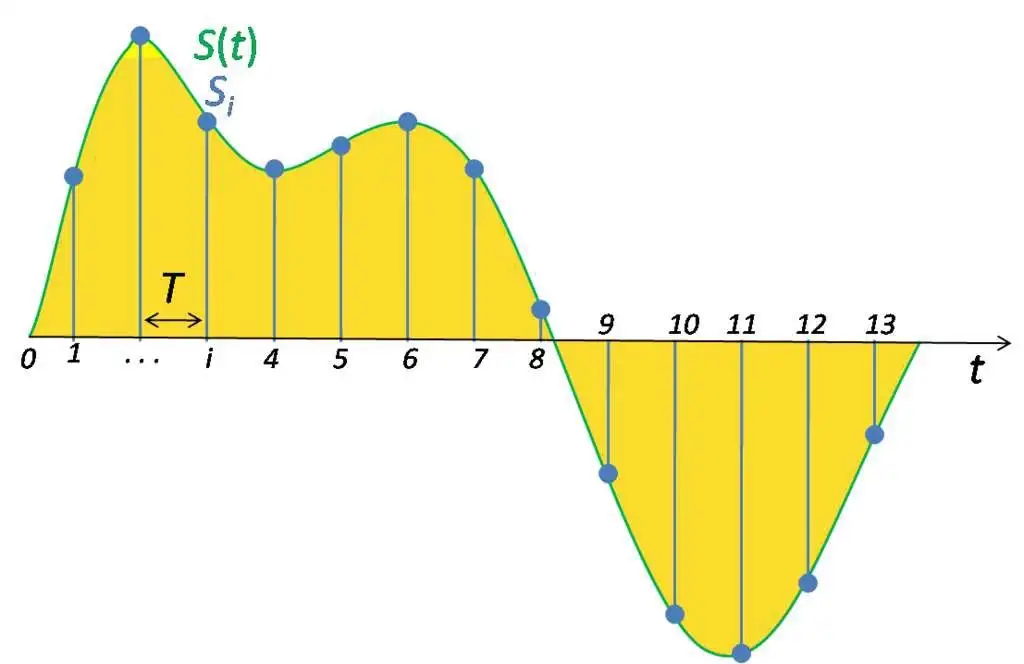


Each such measurement is called a sample, and the sample rate is the number of samples per second. For instance, a common sampling rate is about 44,100 samples per second. That means that a 10-second music clip would have 441,000 samples!
Let's see the average length in times of our dataset adn the mean of samples per audio.

In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
lengths = {}
for label in classes:
  print(f"-- Class {label} --")
  lengths[label] = []
  for file in os.listdir(path + label):
    tensor_wave = load_wav_16k_mono(os.path.join(path + label + "/" + file))
    lengths[label].append(len(tensor_wave))
  print(f"Average samples : {tf.math.reduce_mean(lengths[label])}")
  print(f"Min samples : {tf.math.reduce_min(lengths[label])}")
  print(f"Max samples : {tf.math.reduce_max(lengths[label])}")
  print(f"Number of audios : {len(lengths[label])}")

-- Class yes --


Average samples : 15766
Min samples : 8022
Max samples : 16000
Number of audios : 2377
-- Class no --
Average samples : 15708
Min samples : 7431
Max samples : 16000
Number of audios : 2375
-- Class up --
Average samples : 15652
Min samples : 7510
Max samples : 16000
Number of audios : 963
-- Class stop --
Average samples : 15806
Min samples : 6688
Max samples : 16000
Number of audios : 620
-- Class down --
Average samples : 15734
Min samples : 7510
Max samples : 16000
Number of audios : 597
-- Class one --
Average samples : 15716
Min samples : 8192
Max samples : 16000
Number of audios : 540
-- Class two --
Average samples : 15676
Min samples : 6827
Max samples : 16000
Number of audios : 518
-- Class three --
Average samples : 15756
Min samples : 8875
Max samples : 16000
Number of audios : 519
-- Class four --
Average samples : 15782
Min samples : 8192
Max samples : 16000
Number of audios : 559
-- Class five --
Average samples : 15791
Min samples : 8174
Max samples : 16000
Number of aud

As can be seen from above, some of our waveforms are shorter than 1 second, so from now on we will be complimenting our load load_wav_16k_mono function with pad_with_noise function to ensure that all the files are of the same length

In [8]:
# Load padding wav file from _noise folder (/content/gdrive/MyDrive/speech_recognition/_noise/dude_miaowing.wav)
padding_file = '/content/gdrive/MyDrive/speech_recognition/_noise/dude_miaowing.wav'
padding_contents = tf.io.read_file(padding_file)
padding_waveform, _ = tf.audio.decode_wav(padding_contents, desired_channels=1)
padding_waveform = tf.squeeze(padding_waveform, axis=-1)

In [9]:
def pad_with_noise(file_path):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:16000]

    # Calculate difference in length
    target_length = 16000
    current_length = tf.shape(wav)[0]
    pad_length = target_length - current_length

    # Pad waveform if it is shorter than the target length
    if pad_length > 0:
        padding_start = tf.random.uniform(shape=[], minval=0, maxval=padding_waveform.shape[0] - pad_length, dtype=tf.int32)
        padding_slice = padding_waveform[padding_start : padding_start + pad_length]

        # Pad the waveform with the selected slice
        wav = tf.concat([wav, padding_slice], axis=0)

    return wav

### Waveform

A waveform plot is a visual representation of an audio signal that shows how the amplitude (loudness) of the signal changes over time. It is one of the most common ways to visualize audio data.

In a waveform plot, the horizontal axis represents time, usually measured in seconds, and the vertical axis represents the amplitude of the audio signal. The waveform plot displays the variations in the amplitude of the signal as a continuous line that moves up and down.

Typically, when the audio signal has higher amplitudes, the waveform will appear taller, indicating louder or more intense portions of the audio. Conversely, lower amplitudes will be represented by smaller heights in the waveform plot, indicating quieter sections.

By examining the waveform plot, you can get a sense of the overall structure of the audio signal, identify specific audio events or patterns, and observe characteristics such as the presence of silence, noise, or distinct audio segments.


### Spectrogram

Since a signal produces different sounds as it varies over time, its constituent frequencies also vary with time. In other words, its Spectrum varies with time.

A Spectrogram of a signal plots its Spectrum over time and is like a ‘photograph’ of the signal. It plots Time on the x-axis and Frequency on the y-axis. It is as though we took the Spectrum again and again at different instances in time, and then joined them all together into a single plot.

It uses different colors to indicate the Amplitude or strength of each frequency. The brighter the color the higher the energy of the signal. Each vertical ‘slice’ of the Spectrogram is essentially the Spectrum of the signal at that instant in time and shows how the signal strength is distributed in every frequency found in the signal at that instant.

Spectrograms are produced using Fourier Transforms to decompose any signal into its constituent frequencies.

### Visualiazing

Let's take a sample from every class and take a look at their waveform and spectrogram.

In [10]:
def plot_waveform(waveform):

    # Plot waveform
    ax1.set_title('Waveform')
    ax1.plot(waveform)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')

def plot_spectrogram(waveform):

    # Create spectrogram
    spectrogram = tf.signal.stft(waveform, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    # Plot spectrogram
    ax2.set_title('Spectrogram')
    sp = ax2.imshow(tf.transpose(spectrogram)[0])
    bar = plt.colorbar(sp)
    ax2.set_xlabel('time')
    ax2.set_ylabel('Hz')

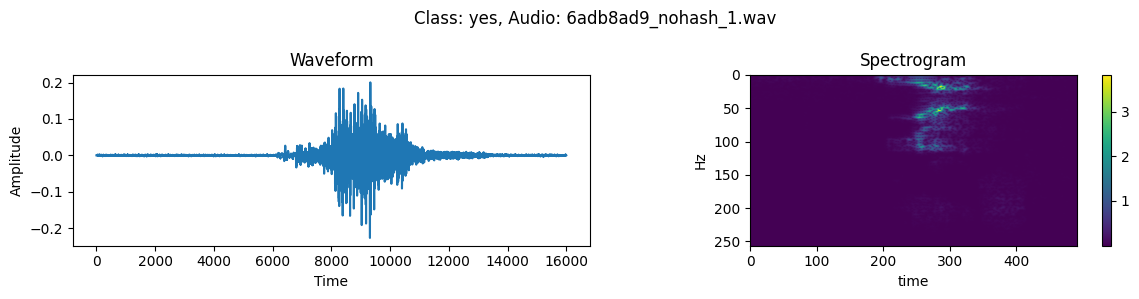

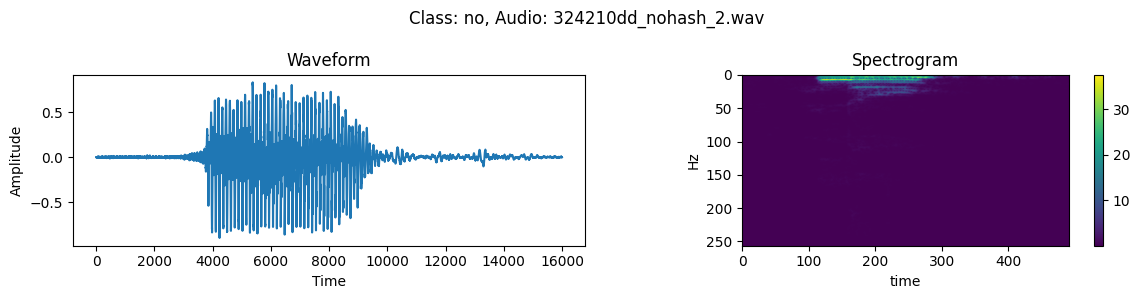

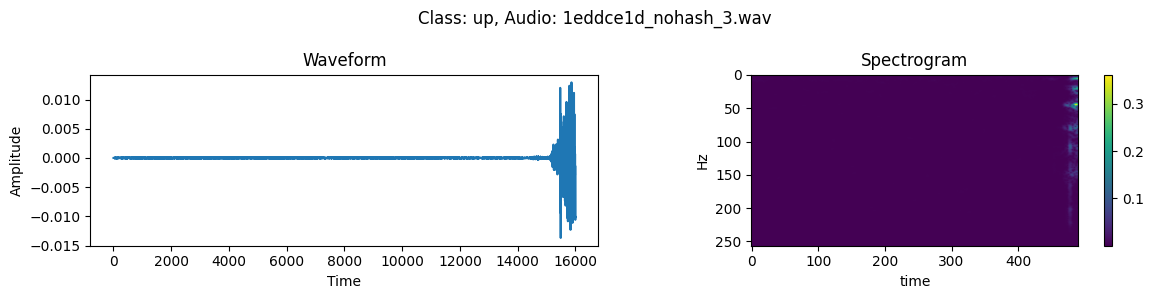

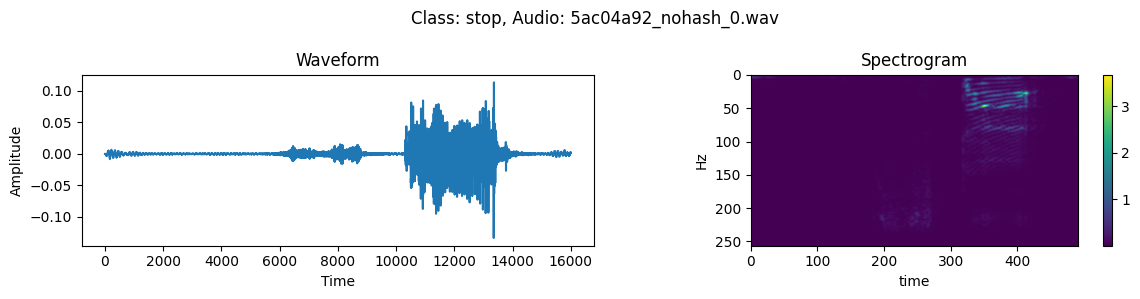

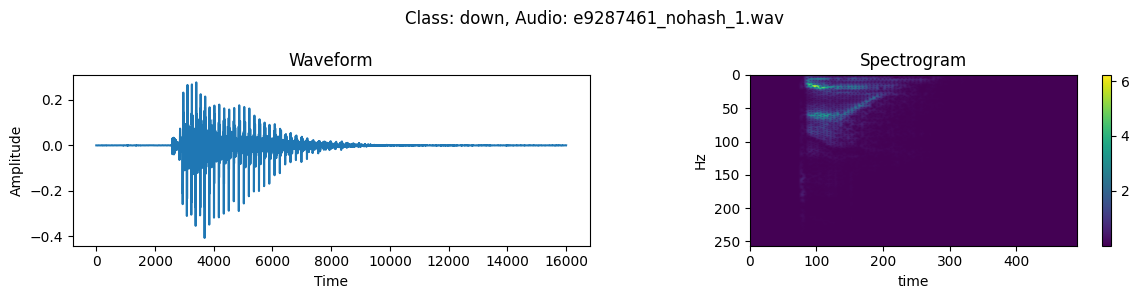

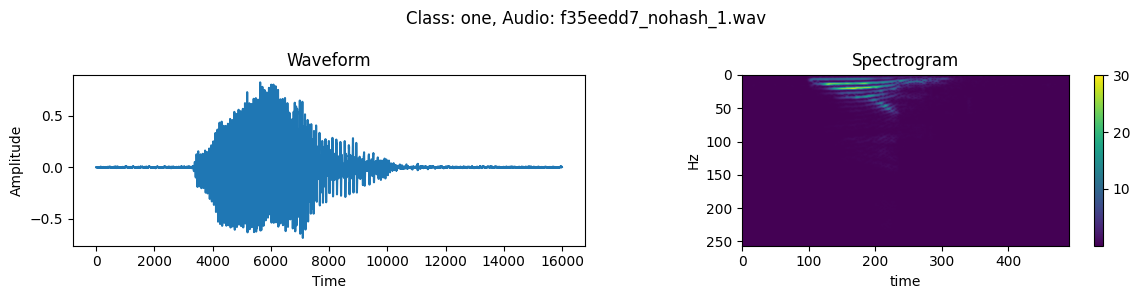

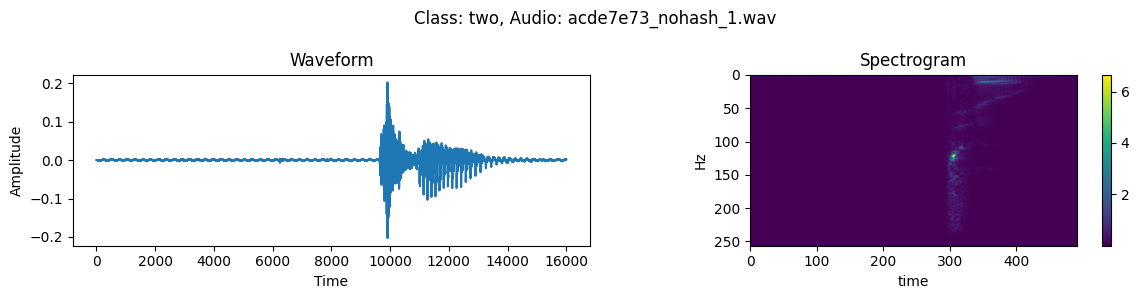

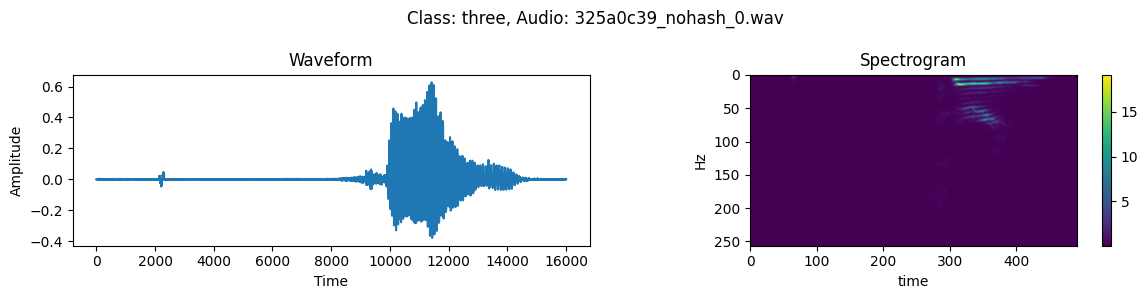

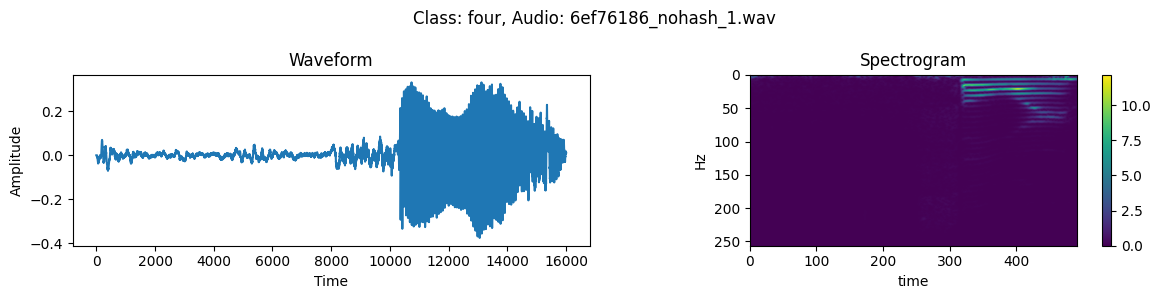

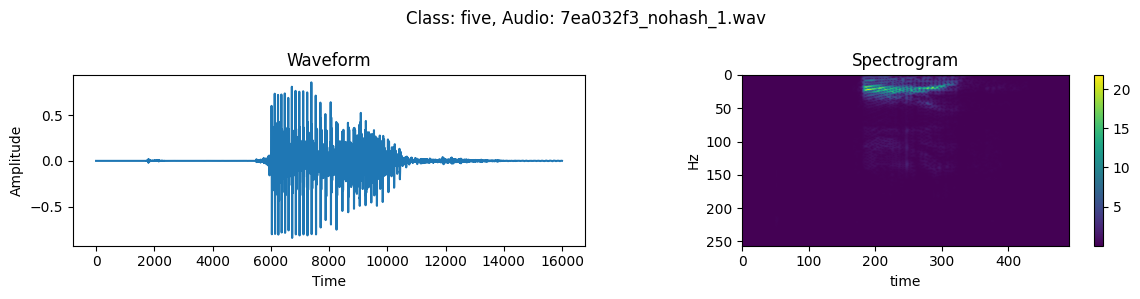

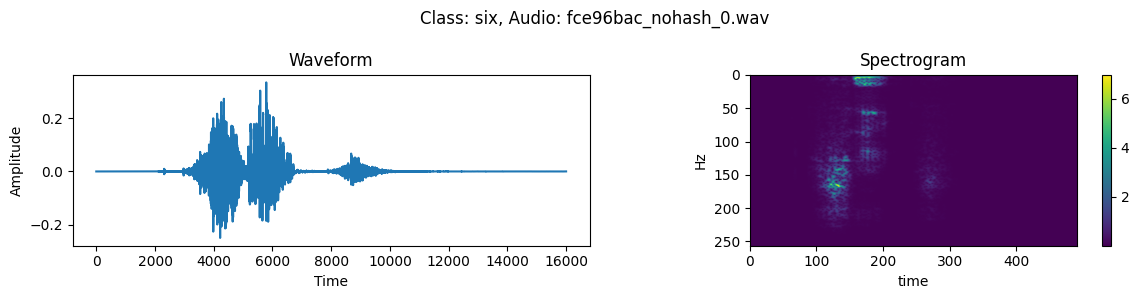

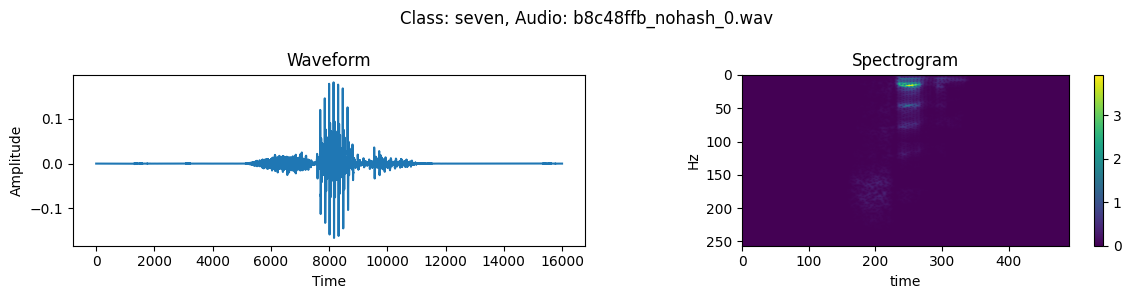

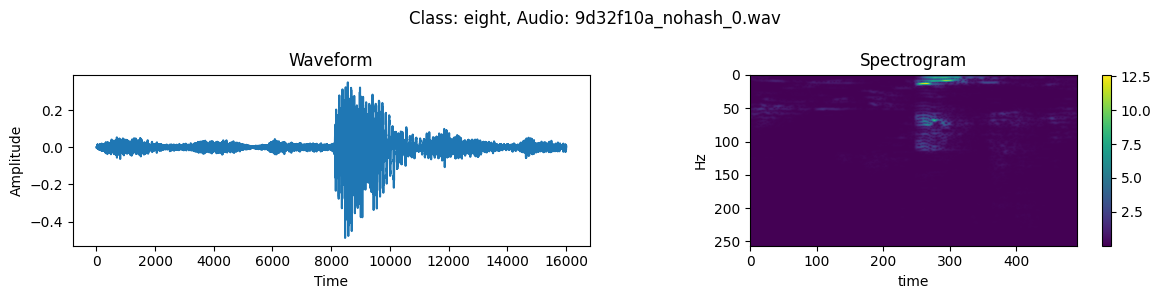

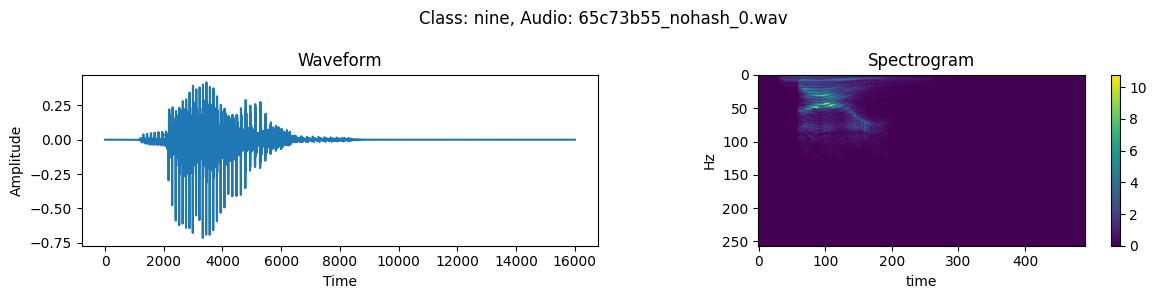

In [11]:
n_samples = 1
for label in classes:
  for _ in range(n_samples):
    audio = random.choice(os.listdir(path + label))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle(f"Class: {label}, Audio: {audio}")

    waveform = pad_with_noise(path + label + '/' + audio)
    plot_waveform(waveform)
    plot_spectrogram(waveform)

    plt.tight_layout()
    plt.show()

From the waveform above we can see that all our audio often starts and ends with a silence period that can be seen on the waveform by having low signal value.
Also, we can see differents pattern for every class. Meaning that an audio with label "seven" will have a different waveform than an audio with label "yes" for example.

Let's check if there is a pattern across each class, i.e. audio with labels "two" for example have similar waveform.

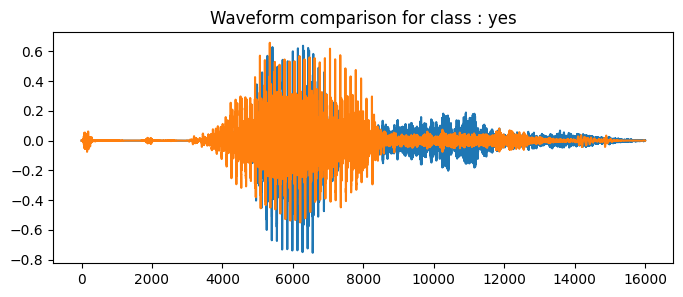

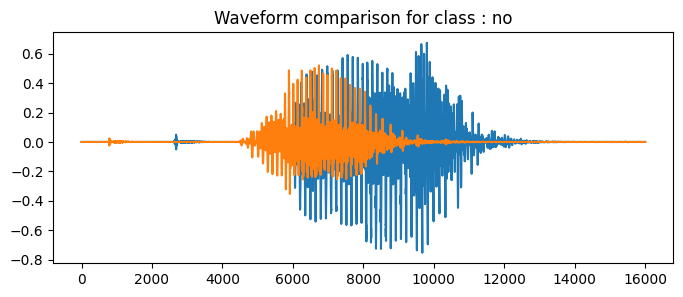

In [12]:
for label in classes[:2]:
  path_class = path + label + "/"
  audio_samples = [path_class + random.choice(os.listdir(path_class)) for _ in range(2)]
  plt.figure(figsize=(8, 3))
  plt.plot(pad_with_noise(audio_samples[0]))
  plt.plot(pad_with_noise(audio_samples[1]))
  plt.title(f"Waveform comparison for class : {label}")
  plt.show()

It seems that there is a pattern but a lot of noise makes it extremely unreadable. Lets plot the average plots for every label

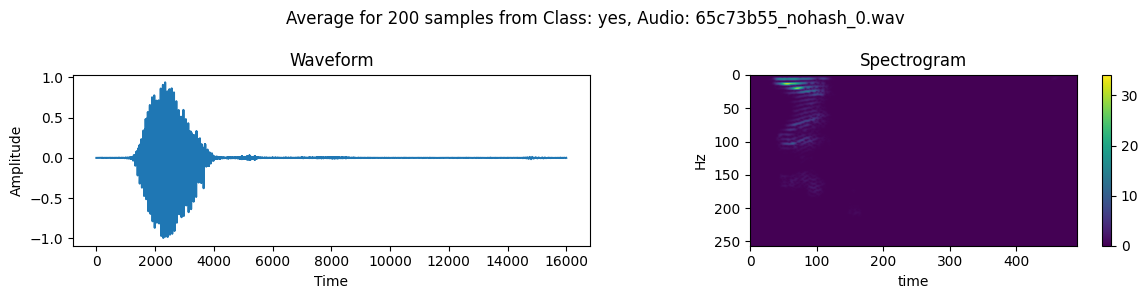

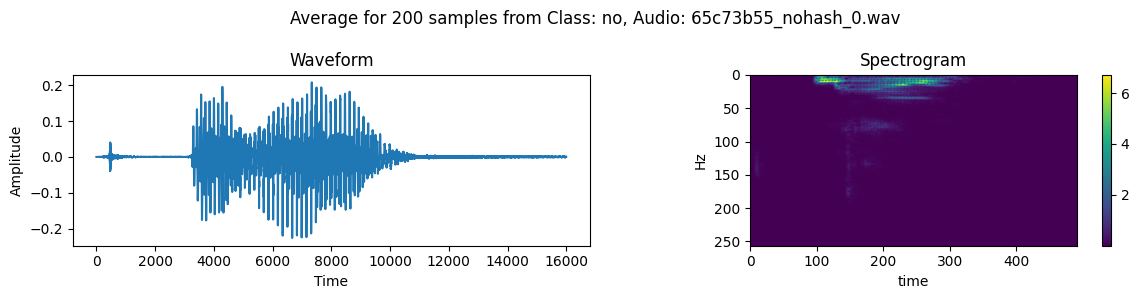

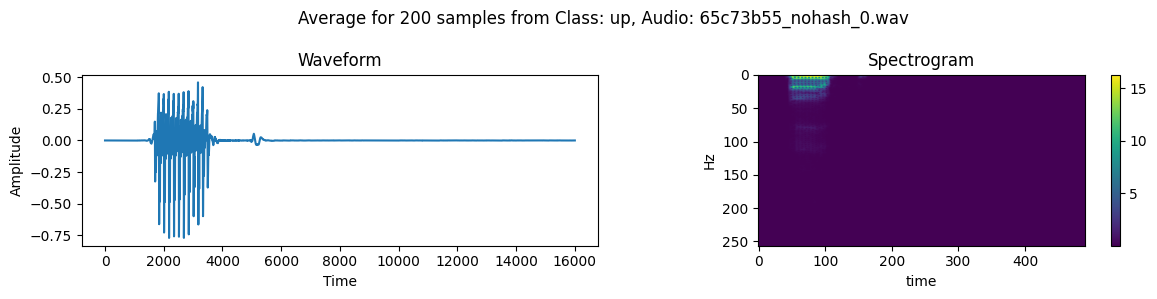

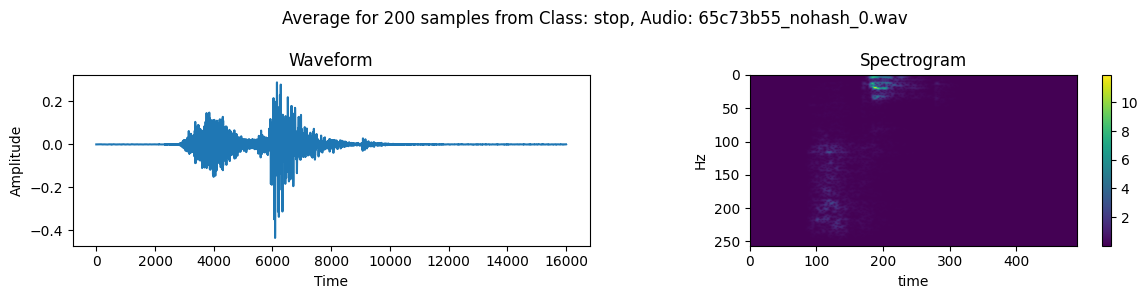

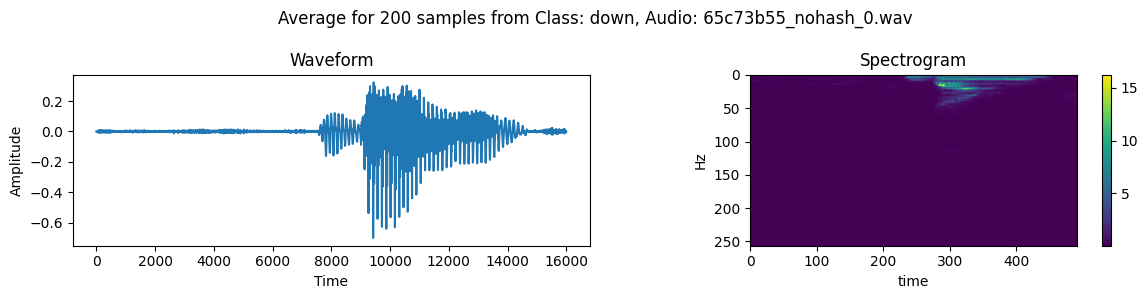

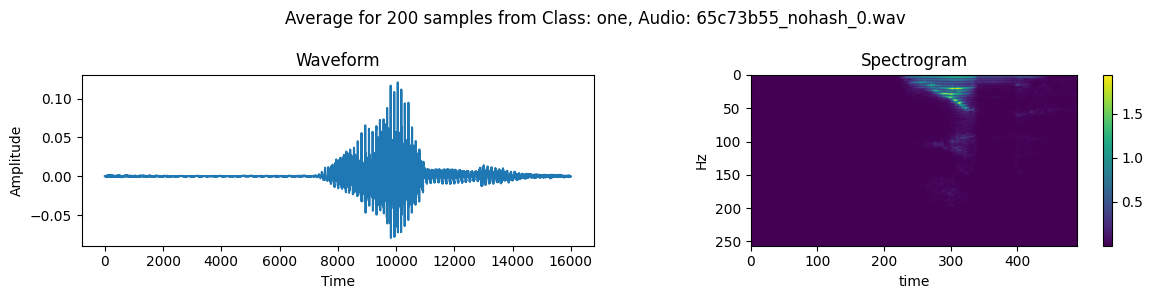

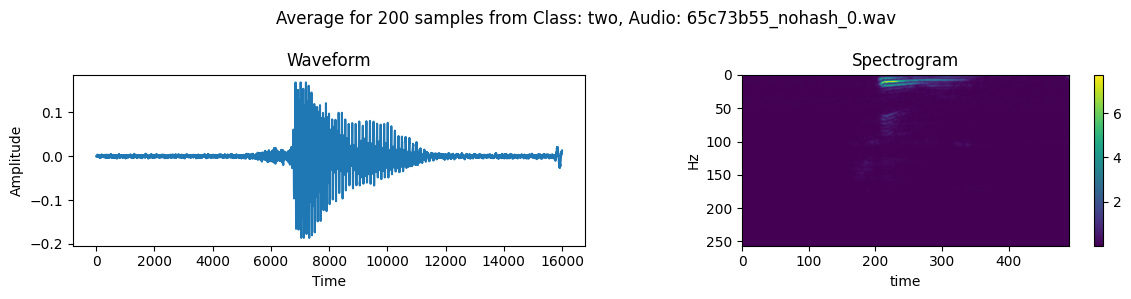

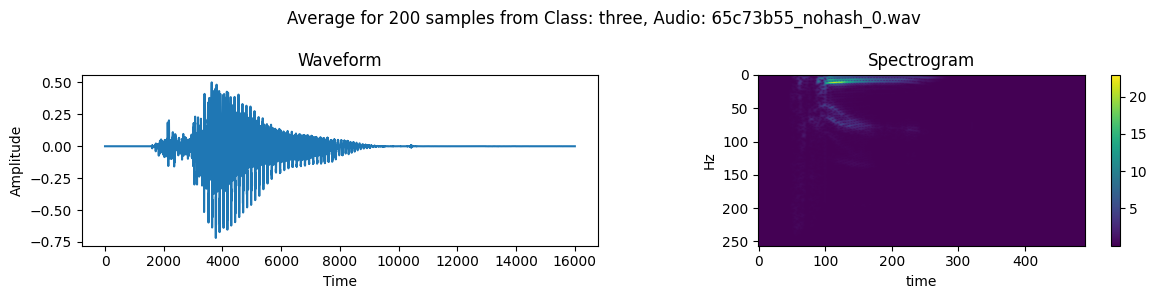

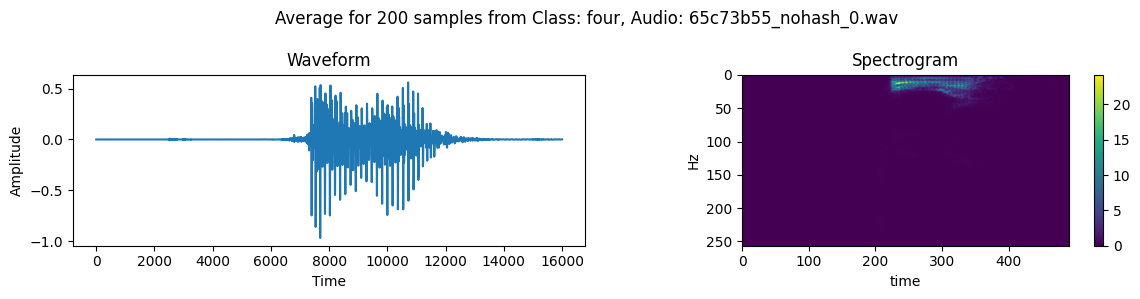

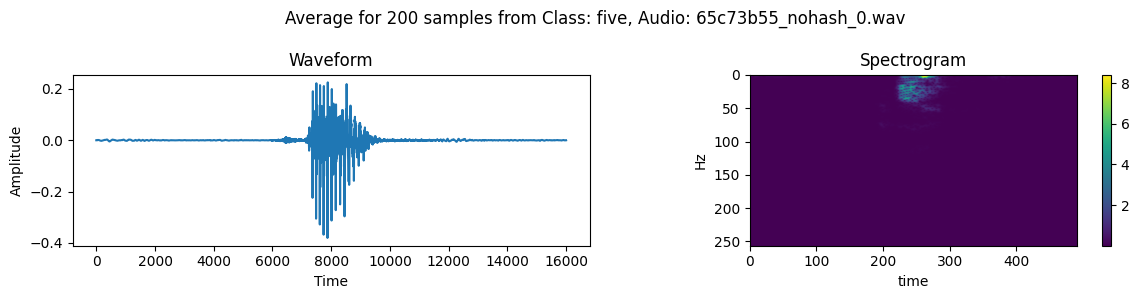

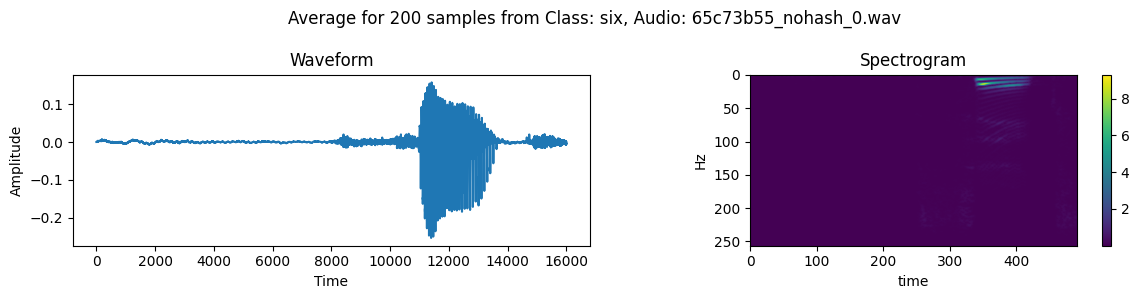

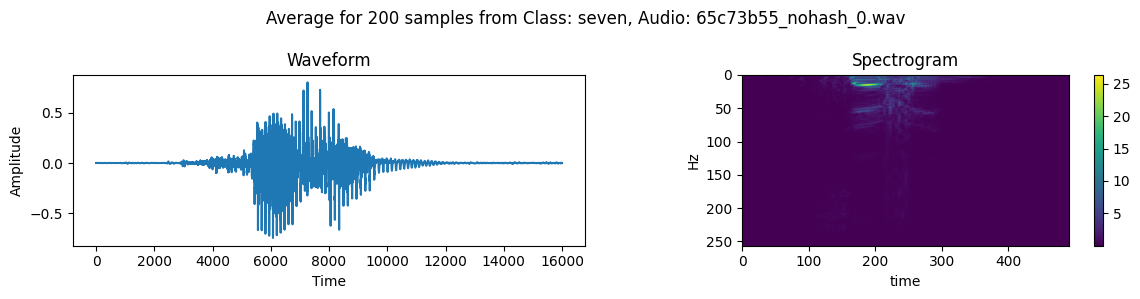

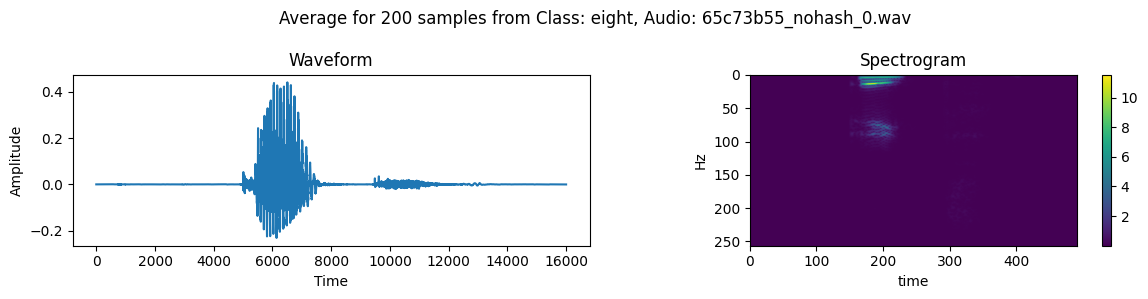

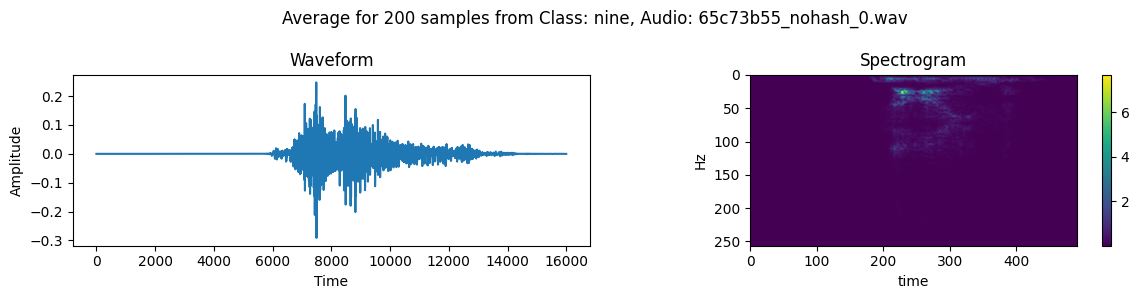

In [13]:
N_to_average = 200
averages = {}

for label in classes:
  count = 0
  for file in os.listdir(path + label):
    waveform = pad_with_noise(os.path.join(path + label + "/" + file))
    count += 1
    if count == 1:
      average_waveform = waveform
    elif count < N_to_average:
      average_waveform = (average_waveform * (count - 1) + waveform) / count
    else:
      averages[label] = average_waveform
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
      fig.suptitle(f"Average for {N_to_average} samples from Class: {label}, Audio: {audio}")
      plot_waveform(waveform)
      plot_spectrogram(waveform)

      plt.tight_layout()
      plt.show()
      break

Now the distinction if more clear, but still far from obvious.

Let's also try to use Mel-frequency Cepstral Coefficients (MFCC):

MFCC is a feature extraction technique widely used in speech and audio processing. It represents the power spectrum of the audio signal on a mel-scale, which approximates human perception of sound. MFCCs capture important spectral characteristics of the waveform, including both the shape of the spectral envelope and the temporal dynamics of the audio. By computing the MFCCs, you can extract patterns related to the spectral content and timbral characteristics of the waveform.

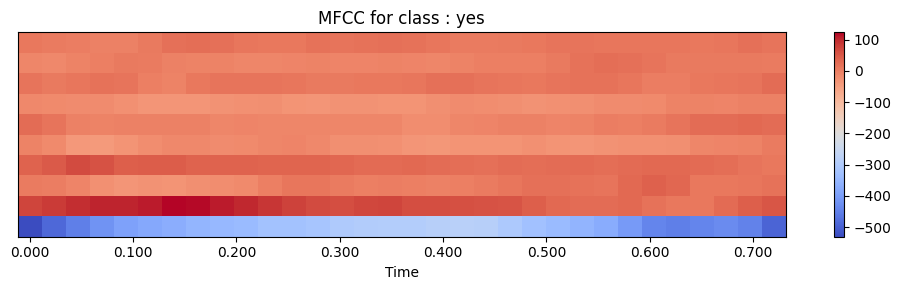

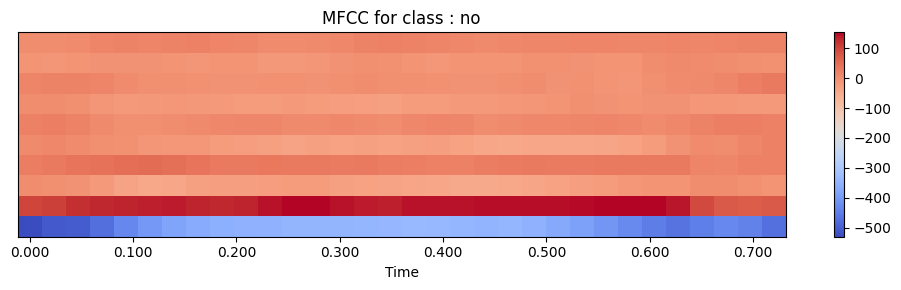

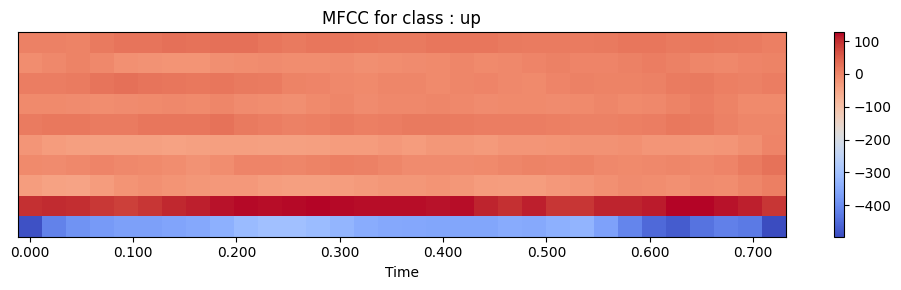

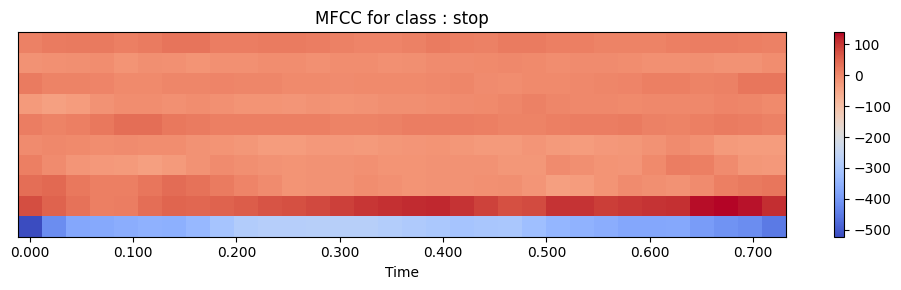

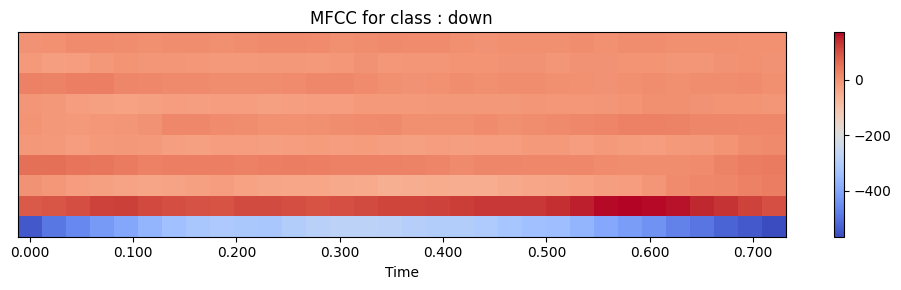

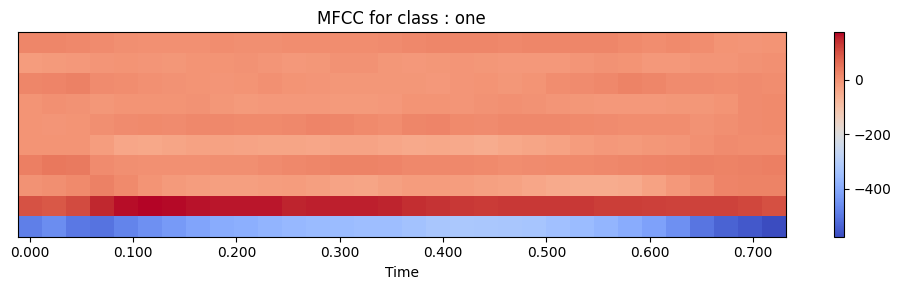

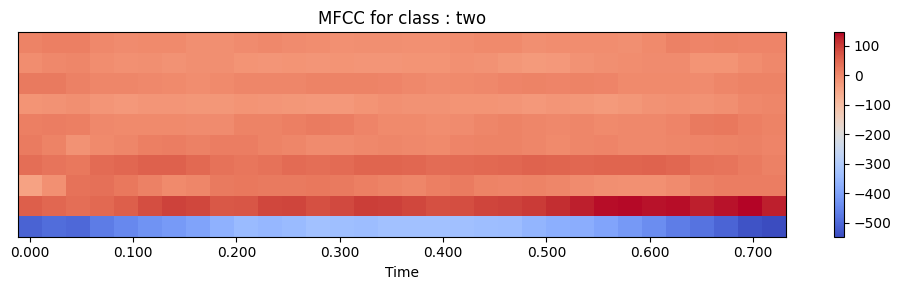

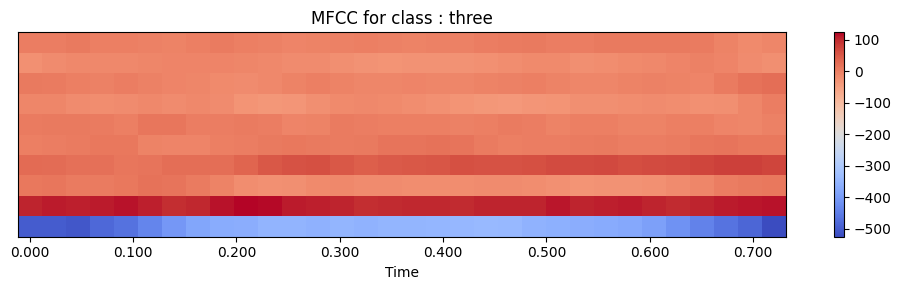

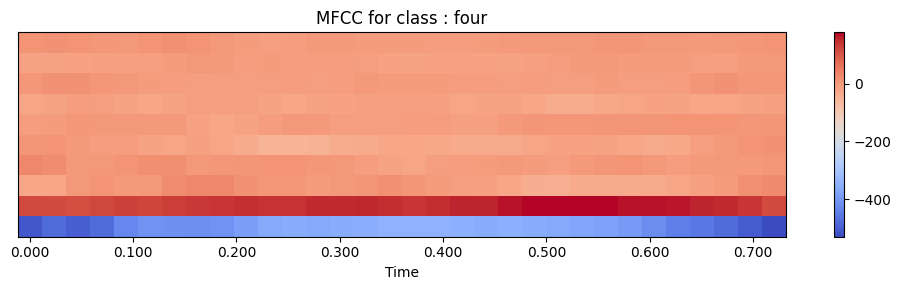

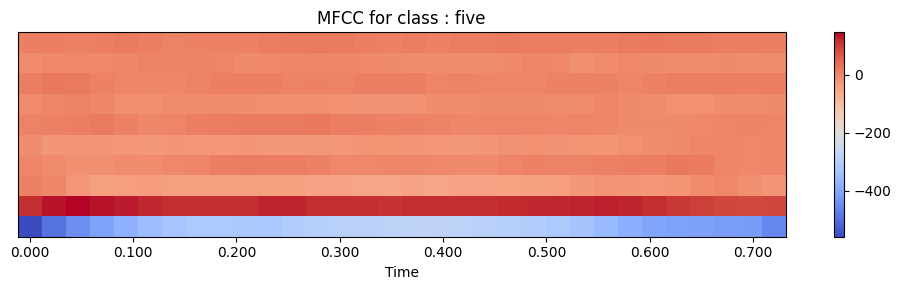

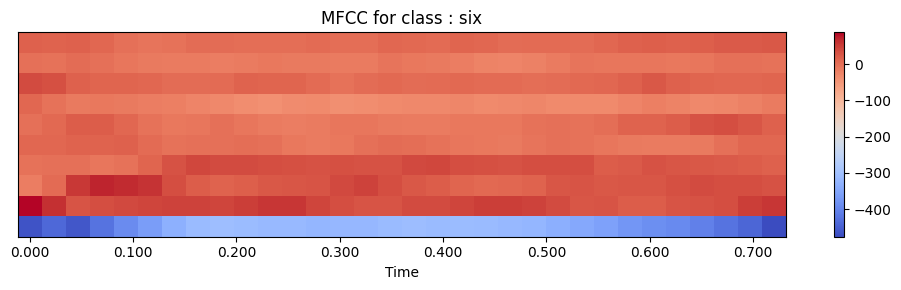

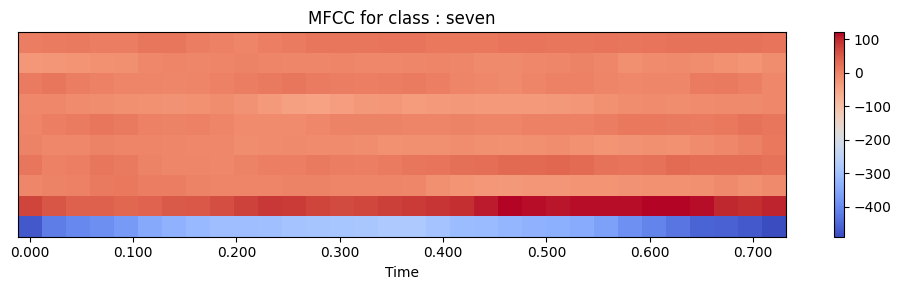

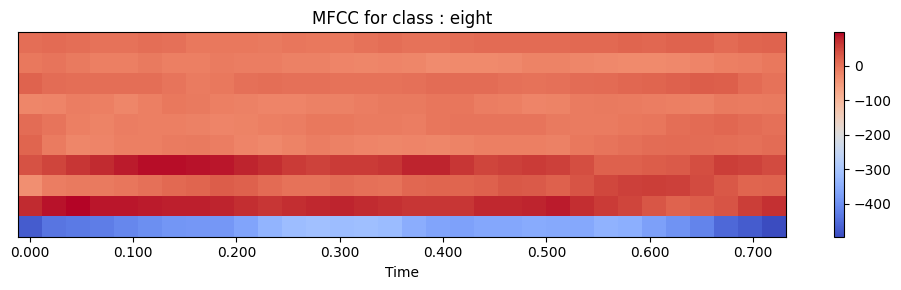

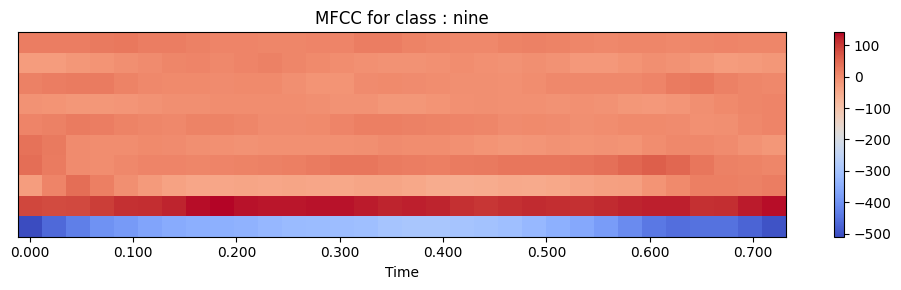

In [14]:
mfccs_by_lebel = {}
for label in classes:
  x = np.array(averages[label])
  sr = 16000
  mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=10)
  mfccs_by_lebel[label] = mfccs
  plt.figure(figsize=(10,3))
  librosa.display.specshow(mfccs, x_axis="time")
  plt.colorbar()
  plt.title(f'MFCC for class : {label}')
  plt.tight_layout()
  plt.show()

Let's compare mfccs for different sound averages analytically

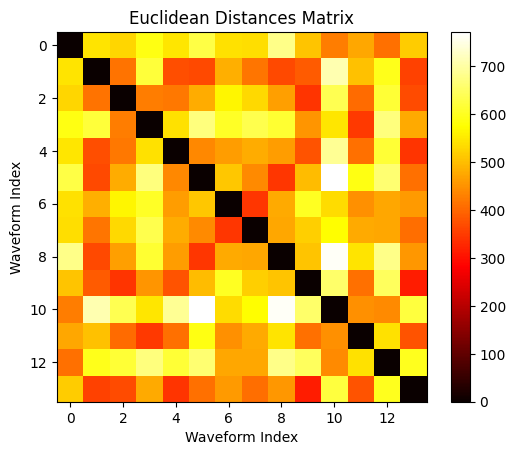

In [16]:
distances = np.zeros((len(classes), len(classes)))
mfccs_list = list(mfccs_by_lebel.values())

for i in range(len(classes)):
  for j in range(i+1, len(classes)):
    # Compute the Euclidean distance between MFCCs for waveform i and waveform j
    distances[i, j] = np.linalg.norm(mfccs_list[i] - mfccs_list[j])
    distances[j, i] = distances[i, j]  # Use symmetry of distance matrix

# Plot the distances matrix as a heatmap
plt.imshow(distances, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add a colorbar to indicate the distance values
plt.title('Euclidean Distances Matrix')
plt.xlabel('Waveform Index')
plt.ylabel('Waveform Index')

plt.show()

From this distance matrix we can see that most of mfccs are quite different from each other.